In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from MlpTSMixer import MlpTSMixerEstimator

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dataset = get_dataset("traffic_nips", regenerate=False)
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [26]:
estimator = MlpTSMixerEstimator(
    # distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="none",
    depth=4,
    patch_size=(5, 20),
    dim=32,
    ablation=False,
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cuda"),
)

In [27]:
predictor = estimator.train(
    training_data=dataset_train,
    cache_data=True,
    shuffle_buffer_length=1024,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | MlpTSMixerModel | 1.2 M 
------------------------------------------
1.2 M     Trainable params
0         Non-train

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached -1.05859 (best -1.05859), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_136/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached -1.32850 (best -1.32850), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_136/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached -1.48840 (best -1.48840), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_136/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached -1.65326 (best -1.65326), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_136/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached -1.66798 (best -1.66798), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_136/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'tra

In [28]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

In [29]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

In [30]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 69.51it/s]

Running evaluation: 7it [00:00, 103.47it/s]

Running evaluation: 7it [00:00, 103.89it/s]

Running evaluation: 7it [00:00, 102.61it/s]

Running evaluation: 7it [00:00, 103.17it/s]

Running evaluation: 7it [00:00, 102.29it/s]

Running evaluation: 7it [00:00, 103.60it/s]

Running evaluation: 7it [00:00, 102.21it/s]

Running evaluation: 7it [00:00, 103.69it/s]

Running evaluation: 7it [00:00, 103.24it/s]

Running evaluation: 7it [00:00, 103.54it/s]

Running evaluation: 7it [00:00, 102.33it/s]

Running evaluation: 7it [00:00, 104.11it/s]

Running evaluation: 7it [00:00, 103.98it/s]

Running evaluation: 7it [00:00, 103.72it/s]

Running evaluation: 7it [00:00, 102.12it/s]

Running evaluation: 7it [00:00, 103.97it/s]

Running evaluation: 7it [00:00, 103.87it/s]

Running evaluation: 7it [00:00, 103.98it/s]

Running evaluation: 7it [00:00, 101.77it/s]

Running evaluation: 7it [00:00, 102.12it/s]

Running evaluation: 7it [00:00, 102.86it/s]

Running ev

Running evaluation: 7it [00:00, 101.41it/s]

Running evaluation: 7it [00:00, 102.49it/s]

Running evaluation: 7it [00:00, 103.05it/s]

Running evaluation: 7it [00:00, 104.32it/s]

Running evaluation: 7it [00:00, 102.36it/s]

Running evaluation: 7it [00:00, 103.07it/s]

Running evaluation: 7it [00:00, 103.96it/s]

Running evaluation: 7it [00:00, 103.07it/s]

Running evaluation: 7it [00:00, 103.78it/s]

Running evaluation: 7it [00:00, 103.19it/s]

Running evaluation: 7it [00:00, 102.65it/s]

Running evaluation: 7it [00:00, 103.06it/s]

Running evaluation: 7it [00:00, 99.08it/s]

Running evaluation: 7it [00:00, 99.51it/s]

Running evaluation: 7it [00:00, 101.29it/s]

Running evaluation: 7it [00:00, 104.54it/s]

Running evaluation: 7it [00:00, 101.68it/s]

Running evaluation: 7it [00:00, 102.21it/s]

Running evaluation: 7it [00:00, 99.11it/s]

Running evaluation: 7it [00:00, 103.45it/s]

Running evaluation: 7it [00:00, 104.05it/s]

Running evaluation: 7it [00:00, 100.55it/s]

Running evalu

Running evaluation: 7it [00:00, 99.82it/s]

Running evaluation: 7it [00:00, 98.64it/s]

Running evaluation: 7it [00:00, 94.63it/s]

Running evaluation: 7it [00:00, 100.73it/s]

Running evaluation: 7it [00:00, 98.73it/s]

Running evaluation: 7it [00:00, 91.49it/s]

Running evaluation: 7it [00:00, 83.08it/s]

Running evaluation: 7it [00:00, 100.19it/s]

Running evaluation: 7it [00:00, 102.78it/s]

Running evaluation: 7it [00:00, 103.56it/s]

Running evaluation: 7it [00:00, 103.55it/s]

Running evaluation: 7it [00:00, 102.34it/s]

Running evaluation: 7it [00:00, 103.73it/s]

Running evaluation: 7it [00:00, 104.19it/s]

Running evaluation: 7it [00:00, 104.11it/s]

Running evaluation: 7it [00:00, 101.31it/s]

Running evaluation: 7it [00:00, 102.60it/s]

Running evaluation: 7it [00:00, 103.97it/s]

Running evaluation: 7it [00:00, 102.76it/s]

Running evaluation: 7it [00:00, 101.62it/s]

Running evaluation: 7it [00:00, 104.05it/s]

Running evaluation: 7it [00:00, 103.62it/s]

Running evaluati

Running evaluation: 7it [00:00, 102.07it/s]

Running evaluation: 7it [00:00, 102.41it/s]

Running evaluation: 7it [00:00, 103.70it/s]

Running evaluation: 7it [00:00, 103.20it/s]

Running evaluation: 7it [00:00, 99.64it/s]

Running evaluation: 7it [00:00, 102.76it/s]

Running evaluation: 7it [00:00, 103.32it/s]

Running evaluation: 7it [00:00, 102.86it/s]

Running evaluation: 7it [00:00, 86.39it/s]

Running evaluation: 7it [00:00, 92.69it/s]

Running evaluation: 7it [00:00, 104.23it/s]

Running evaluation: 7it [00:00, 99.74it/s]

Running evaluation: 7it [00:00, 102.94it/s]

Running evaluation: 7it [00:00, 97.36it/s]

Running evaluation: 7it [00:00, 97.61it/s]

Running evaluation: 7it [00:00, 102.39it/s]

Running evaluation: 7it [00:00, 102.58it/s]

Running evaluation: 7it [00:00, 101.93it/s]

Running evaluation: 7it [00:00, 101.66it/s]

Running evaluation: 7it [00:00, 102.31it/s]

Running evaluation: 7it [00:00, 102.77it/s]

Running evaluation: 7it [00:00, 101.67it/s]

Running evaluati

Running evaluation: 7it [00:00, 103.79it/s]

Running evaluation: 7it [00:00, 103.70it/s]

Running evaluation: 7it [00:00, 103.62it/s]

Running evaluation: 7it [00:00, 103.05it/s]

Running evaluation: 7it [00:00, 103.60it/s]

Running evaluation: 7it [00:00, 102.93it/s]

Running evaluation: 7it [00:00, 103.21it/s]

Running evaluation: 7it [00:00, 103.59it/s]

Running evaluation: 7it [00:00, 104.06it/s]

Running evaluation: 7it [00:00, 103.20it/s]

Running evaluation: 7it [00:00, 103.48it/s]

Running evaluation: 7it [00:00, 103.10it/s]

Running evaluation: 7it [00:00, 103.66it/s]

Running evaluation: 7it [00:00, 103.84it/s]

Running evaluation: 7it [00:00, 103.95it/s]

Running evaluation: 7it [00:00, 103.19it/s]

Running evaluation: 7it [00:00, 102.37it/s]

Running evaluation: 7it [00:00, 103.74it/s]

Running evaluation: 7it [00:00, 104.02it/s]

Running evaluation: 7it [00:00, 102.91it/s]

Running evaluation: 7it [00:00, 104.03it/s]

Running evaluation: 7it [00:00, 103.15it/s]

Running ev

Running evaluation: 7it [00:00, 102.70it/s]

Running evaluation: 7it [00:00, 101.01it/s]

Running evaluation: 7it [00:00, 102.02it/s]

Running evaluation: 7it [00:00, 102.14it/s]

Running evaluation: 7it [00:00, 101.90it/s]

Running evaluation: 7it [00:00, 101.74it/s]

Running evaluation: 7it [00:00, 102.88it/s]

Running evaluation: 7it [00:00, 100.38it/s]

Running evaluation: 7it [00:00, 103.02it/s]

Running evaluation: 7it [00:00, 102.91it/s]

Running evaluation: 7it [00:00, 102.87it/s]

Running evaluation: 7it [00:00, 102.95it/s]

Running evaluation: 7it [00:00, 102.23it/s]

Running evaluation: 7it [00:00, 95.78it/s]

Running evaluation: 7it [00:00, 99.52it/s]

Running evaluation: 7it [00:00, 102.98it/s]

Running evaluation: 7it [00:00, 103.10it/s]

Running evaluation: 7it [00:00, 101.74it/s]

Running evaluation: 7it [00:00, 103.25it/s]

Running evaluation: 7it [00:00, 98.93it/s]

Running evaluation: 7it [00:00, 103.32it/s]

Running evaluation: 7it [00:00, 102.34it/s]

Running evalu

In [9]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.20149867768505367
ND: 0.26452282086128487
NRMSE: 0.5338347407490169
MSE: 0.0007816111095213352


In [23]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

print("CRPS-SUM: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))

CRPS: 0.20037196022176634
ND: 0.2625194907515909
NRMSE: 0.5328783932238198
MSE: 0.0007788131563736039
CRPS-SUM: 0.11132506377543837


In [15]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

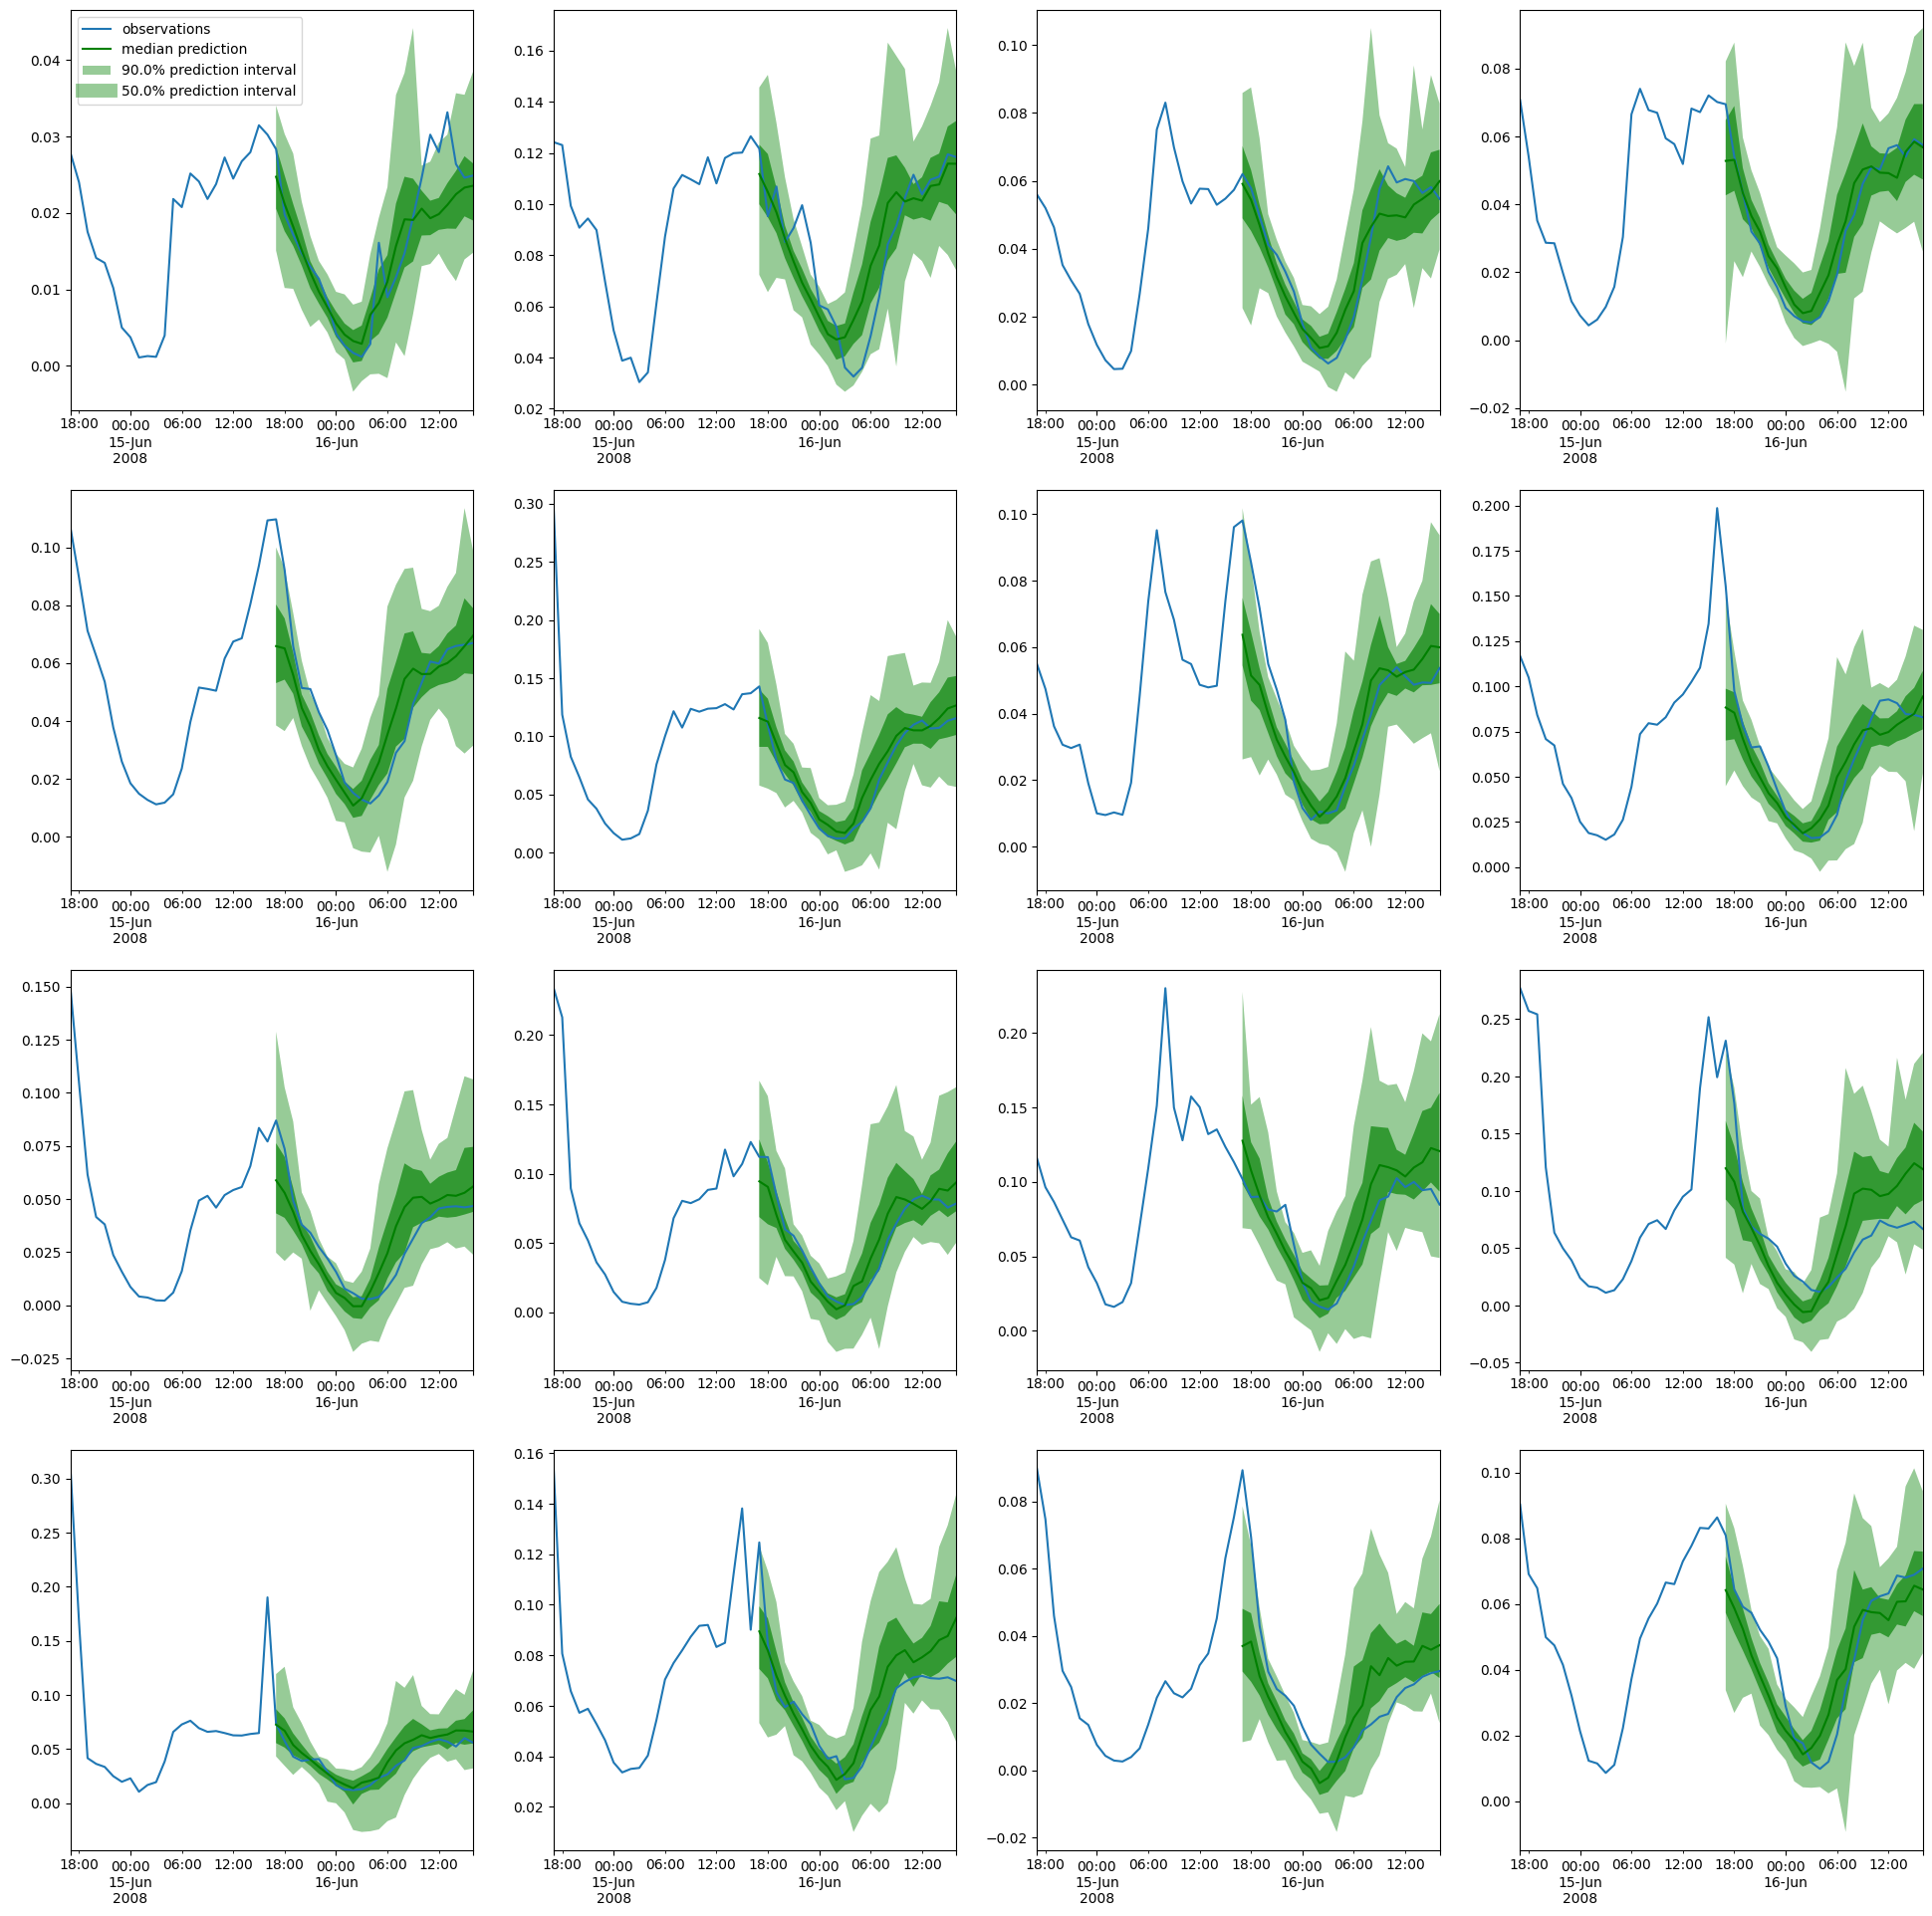

In [16]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()